In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mushroom_module
from mushroom_module import plogp
from mushroom_module import Plot_Preparation

In [5]:
#Reading in the csv, csv does not have headers
df = pd.read_csv(r'C:\CodingProjects\Mushroom\UCIrvine_Mushroom_Data\agaricus-lepiota.data', header=None)

In [6]:
#Brought in the schema from the README as a list
schema = ['Edible', 'Cap Shape', 'Cap Surface', 'Cap Color', 'Bruises?', 'Odor',
          'Gill Attachment', 'Gill Spacing', 'Gill Size', 'Gill Color', 'Stalk Shape', 'Stalk Root',
          'Stalk Surface Above Ring', 'Stalk Surface Below Ring', 'Stalk Color Above Ring', 'Stalk Color Below Ring',
          'Veil Type', 'Veil Color', 'Ring Number', 'Ring Type', 'Spore Print Color', 'Population', 'Habitat']

In [7]:
#Overwriting dataframe column headers with labels from schema
df.columns = schema
df.head()

,Edible,Cap Shape,Cap Surface,Cap Color,Bruises?,Odor,Gill Attachment,Gill Spacing,Gill Size,Gill Color,...,Stalk Surface Below Ring,Stalk Color Above Ring,Stalk Color Below Ring,Veil Type,Veil Color,Ring Number,Ring Type,Spore Print Color,Population,Habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## Checking Data Quality

In [8]:
#Look at the data types and counts in df. We know that one column, Stalk Root, has missing values marked by ?
df.info()
df['Stalk Root'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Edible                    8124 non-null   object
 1   Cap Shape                 8124 non-null   object
 2   Cap Surface               8124 non-null   object
 3   Cap Color                 8124 non-null   object
 4   Bruises?                  8124 non-null   object
 5   Odor                      8124 non-null   object
 6   Gill Attachment           8124 non-null   object
 7   Gill Spacing              8124 non-null   object
 8   Gill Size                 8124 non-null   object
 9   Gill Color                8124 non-null   object
 10  Stalk Shape               8124 non-null   object
 11  Stalk Root                8124 non-null   object
 12  Stalk Surface Above Ring  8124 non-null   object
 13  Stalk Surface Below Ring  8124 non-null   object
 14  Stalk Color Above Ring  

Stalk Root
b    3776
?    2480
e    1120
c     556
r     192
Name: count, dtype: int64

In [9]:
#Stalk Root shows 8124 data, but some of that data is unknown ("?"). To clean the data, we need to change the "?"" to NULL
for i in df['Stalk Root']:
    df['Stalk Root'] = df['Stalk Root'].replace('?', np.nan)

## Calculate parent set entropy
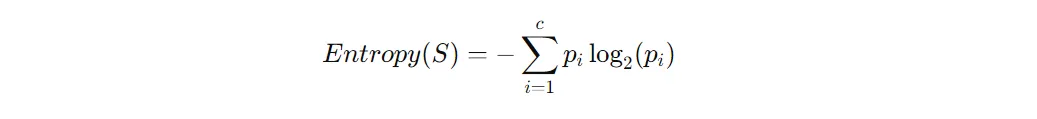
https://medium.com/biased-algorithms/understanding-information-gain-in-decision-trees-a-complete-guide-|7774c6e0255b#:~:text=Information%20Gain%20helps%20measure%20exactly,each%20subset%20after%20the%20split.

##### Entropy measures the amount of order in a set. For example, if a set has 2 possible values, and the probability that each value occurs in the set is 50%, then the entropy is maximized for the set, which suggests that the set is most unordered. Any other split of proportions for the two values would generate a lower entropy value. Entropy is calculated for the set using the above eqation, where i is each value in the set, p~i~ is the proportion of the value in the set, and N is the total number of different values in the set.

##### We can split the entire mushroom set into two child sets, mushrooms that are edible and mushrooms that are poisonous. From there, we can apply the above equation, where each p~i~ is the count of edible mushrooms divided by total mushrooms or poisonous mushrooms divided by total mushrooms. The two quantities are then passed through the function p * log~2~(p), and the two outputs are summed together and multiplied by -1 to arrive at the parent set entropy. 

In [10]:
#Get the count of each value in the target variable
parent_counts = df['Edible'].value_counts()
#get the total count of all mushrooms
total_count = df['Edible'].count()

In [8]:
parent_counts

Edible
e    4208
p    3916
Name: count, dtype: int64

In [11]:
print(total_count)

8124


In [12]:
#calculate probability of each value in the parent set
parent_probs = parent_counts / total_count

In [17]:
#calculate the log base 2 of probability of each value in the parent set
parent_logprobs = np.log2(parent_probs)

In [16]:
#calculate the product of probability and log(probability) for each value. Log is base 2.
parent_value_entropy = parent_probs*parent_logprobs

In [18]:
#calculate the parent set entropy as the sum of the negative of the two terms in parent_value_entropy
parent_set_entropy = 0
for i in parent_value_entropy:
    i = -i
    parent_set_entropy = parent_set_entropy + i

In [19]:
#print
print(f'Entropy of parent set: ', parent_set_entropy)

Entropy of parent set:  0.9990678968724603


##### As we can see, the entropy of the parent set is high, therefore we can say that the parent set is more evenly distributed amongst edible and poisonous mushrooms.

##### Next, we will assess entropy for the sets split by each of the 22 different attributes to compare and see if any attributes yield a better predictive power for edible mushrooms over the parent set.

## Calculate entropy for each set of the parent set split on each attribute
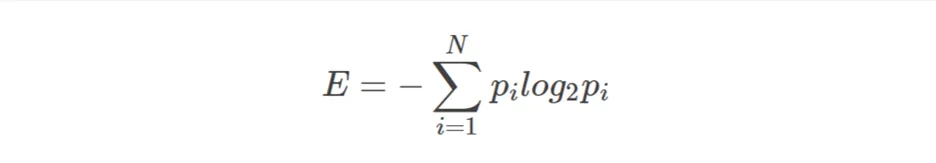
https://medium.com/biased-algorithms/understanding-information-gain-in-decision-trees-a-complete-guide-7774c6e0255b#:~:text=Information%20Gain%20helps%20measure%20exactly,each%20subset%20after%20the%20split.

The entire set can be split 22 ways, for each of the mushroom attributes in the dataset. Each split yields a different number of potential values that the set can be split into, the highest being the attribute "Gill Color' which has 12 different possible values.

The goal of this exercise is to split the parent set on each of the 22 different attributes, which yields N buckets of mushroom data with a mix of poisonous and edible mushrooms. The entropy of the child sets is then calculated using the above formula. 

In [15]:
df['Stalk Root'].count()

np.int64(5644)

In [16]:
#making a matrix of the count of edible / poisonous mushrooms for each set that is split from the parent set by attribute
attr_counts = {}
#loop through each column, grouping rows by values in the column and also p or e in Edible and counting them up with size()
for column in df.columns[1:]:
    count_df = df.groupby([column, 'Edible']).size().unstack(fill_value=0)
    #store results in attr_counts
    attr_counts[column] = count_df   

In [17]:
#for each value in attr_counts, within each dataframe divide each value in each row by the sum of that row
attr_proportion = {}
for key in attr_counts:
    proportion_df = attr_counts[key].div(attr_counts[key].sum(axis=1), axis=0)
    attr_proportion[key] = proportion_df

In [18]:
#calculate p * log_2(p) for each probability in each dataframe for each key
attr_plogprob = {}
for key in attr_proportion:
    proplogprop = attr_proportion[key].map(plogp)
    attr_plogprob[key] = proplogprop
    

In [19]:
#First sum row-wise, and then take the sum of each row and multiply by the proportion that each row value occurs in the larger set
attr_wa_entropy = {}
for key in attr_plogprob:
    row_sum = attr_plogprob[key].sum(axis=1)
    prop_in_set = attr_counts[key].sum(axis=1) / (attr_counts[key].values.sum())
    attr_set_entropy = -1 * row_sum * prop_in_set
    attr_wa_entropy[key] = attr_set_entropy.values.sum()

## Information Gain
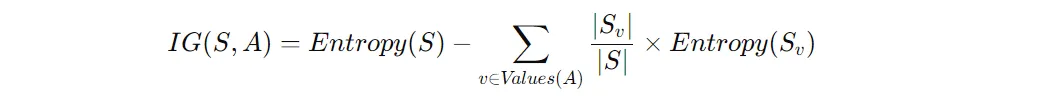
https://medium.com/biased-algorithms/understanding-information-gain-in-decision-trees-a-complete-guide-7774c6e0255b#:~:text=Information%20Gain%20helps%20measure%20exactly,each%20subset%20after%20the%20split.

In [20]:
attr_infogain = {}
for key in attr_wa_entropy:
    infogain = parent_set_entropy - attr_wa_entropy[key]
    attr_infogain[key] = infogain

In [21]:
print(parent_set_entropy)

print(dict(sorted(attr_infogain.items(), key=lambda item: item[1], reverse=True)))

0.9990678968724603
{'Odor': np.float64(0.9060749773839998), 'Spore Print Color': np.float64(0.4807049176849153), 'Gill Color': np.float64(0.41697752341613137), 'Ring Type': np.float64(0.3180215107935376), 'Stalk Surface Above Ring': np.float64(0.2847255992184844), 'Stalk Surface Below Ring': np.float64(0.2718944733927463), 'Stalk Color Above Ring': np.float64(0.2538451734622398), 'Stalk Color Below Ring': np.float64(0.24141556652756646), 'Gill Size': np.float64(0.23015437514804604), 'Population': np.float64(0.2019580190668523), 'Bruises?': np.float64(0.19237948576121955), 'Habitat': np.float64(0.156833604605092), 'Stalk Root': np.float64(0.136965149496745), 'Gill Spacing': np.float64(0.10088318399657026), 'Cap Shape': np.float64(0.04879670193537289), 'Ring Number': np.float64(0.03845266924309043), 'Cap Color': np.float64(0.0360492829762038), 'Cap Surface': np.float64(0.028590232773772706), 'Veil Color': np.float64(0.02381701612091669), 'Gill Attachment': np.float64(0.014165027250616191

## Plotting Attribute Entropy

##### The entropy distribution for values within selected attributes will be plotted. Attributes chosen will be the maximum info gain, median info gain, and minimum info gain

In [22]:
from statistics import median

In [23]:
len(attr_infogain)

22

In [24]:
max_infogain = max(attr_infogain, key=attr_infogain.get)
#calculate median
if len(attr_infogain) % 2 == 0:
    rough_median = int(len(attr_infogain) / 2)
else:
    rough_median = int(len(attr_infogain))
median_infogain = list(sorted(attr_infogain.items(), key=lambda item: item[1], reverse=True))[rough_median]
#calculate min
min_infogain = min(attr_infogain, key=attr_infogain.get)

In [25]:
print( f'The attribute with the highest info gain is', max_infogain, '\nThe attribute with median info gain is', median_infogain[0], '\nThe attribute with the lowest info gain is', min_infogain)

The attribute with the highest info gain is Odor 
The attribute with median info gain is Habitat 
The attribute with the lowest info gain is Veil Type


In [26]:
maxim = Plot_Preparation(max_infogain, attr_counts, attr_plogprob)

In [27]:
type(maxim)

list

In [28]:
maxim

[Odor
 a    0.049237
 c    0.023634
 f    0.265879
 l    0.049237
 m    0.004431
 p    0.031512
 s    0.070901
 y    0.070901
 n    0.434269
 dtype: float64,
 Odor
 a   -0.000000
 c   -0.000000
 f   -0.000000
 l   -0.000000
 m   -0.000000
 p   -0.000000
 s   -0.000000
 y   -0.000000
 n    0.214137
 dtype: float64,
 'Odor']

In [101]:
def plot_attribute_entropy(x: pd.Series, y: pd.Series, z: pd.Index, a: str):
    xpos = []
    c = 0
    for i in range(len(x)):
        if i == 0:
            c += x[i]
            xpos.append(x[i]/2)
        else:
            c += x[i]
            xpos.append(c - x[i]/2)
    #all_colors = ['red', 'gold', 'green', 'blue', 'orange', 'purple', 'yellow', 'pink', 'lightseagreen', 'chartreuse', 'lightsteelblue']
    #all_colors = ['black', 'dimgray', 'gray', 'darkgray', 'silver', 'lightgray', 'gainsboro', 'whitesmoke', 'white', 'chartreuse', 'lightsteelblue']
    #colors = all_colors[0:len(x)]
    ax = plt.bar(xpos, 
              height = y, 
              width = x, 
              color = 'white',
              alpha = 0.5,
              hatch = '/',
              edgecolor = 'black'
             )
    #plt.xticks(ticks = xpos, labels = z)
    #plt.xticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]
    plt.tick_params(direction = 'in', length = 0.2)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    #plt.legend(fig.patches, z)
    rects = ax.patches
    for rect, label in zip(rects, z):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height/2, label, ha='center', va = 'bottom', backgroundcolor = 'white', bbox=dict(facecolor ='white', boxstyle='square'))
    plt.grid(linestyle='dashed')
    #plt.step(x, y, where='post')
    plt.xlabel('Proportion')
    plt.ylabel('Entropy')
    plt.title(f'Entropy Chart for {a} Attribute')
    #plt.grid(True)

    plt.show()   

C:\Users\Josh's PC\AppData\Local\Temp\ipykernel_22108\1267464453.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c += x[i]
C:\Users\Josh's PC\AppData\Local\Temp\ipykernel_22108\1267464453.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xpos.append(x[i]/2)
C:\Users\Josh's PC\AppData\Local\Temp\ipykernel_22108\1267464453.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c += x[i]
C:\Users\Josh's PC\AppData\Local\Temp\ipykern

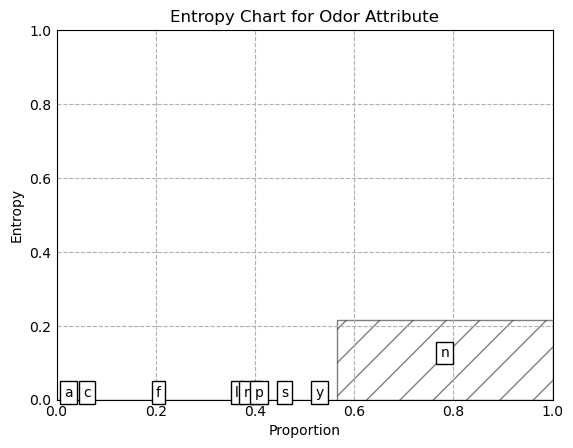

In [102]:
plot_attribute_entropy(maxim[0], maxim[1], maxim[0].index, maxim[2])

In [103]:
media = Plot_Preparation(median_infogain[0], attr_counts, attr_plogprob)

C:\Users\Josh's PC\AppData\Local\Temp\ipykernel_22108\1267464453.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c += x[i]
C:\Users\Josh's PC\AppData\Local\Temp\ipykernel_22108\1267464453.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xpos.append(x[i]/2)
C:\Users\Josh's PC\AppData\Local\Temp\ipykernel_22108\1267464453.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c += x[i]
C:\Users\Josh's PC\AppData\Local\Temp\ipykern

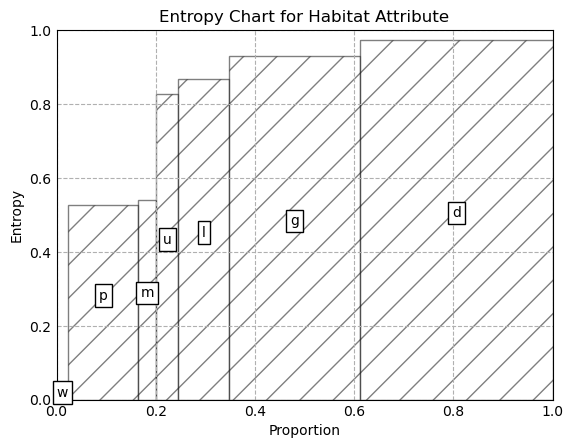

In [104]:
plot_attribute_entropy(media[0], media[1], media[0].index, media[2])

In [105]:
minim = Plot_Preparation(min_infogain, attr_counts, attr_plogprob)

C:\Users\Josh's PC\AppData\Local\Temp\ipykernel_22108\1267464453.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c += x[i]
C:\Users\Josh's PC\AppData\Local\Temp\ipykernel_22108\1267464453.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xpos.append(x[i]/2)


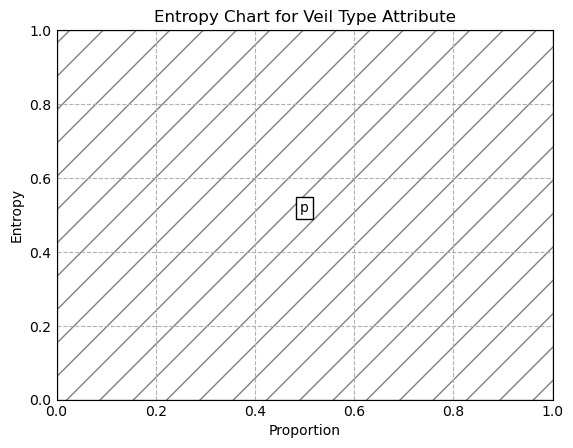

In [112]:
plot_attribute_entropy(minim[0], minim[1], minim[0].index, minim[2])

In [109]:
stalkrt = Plot_Preparation('Stalk Root', attr_counts, attr_plogprob)

C:\Users\Josh's PC\AppData\Local\Temp\ipykernel_22108\1267464453.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c += x[i]
C:\Users\Josh's PC\AppData\Local\Temp\ipykernel_22108\1267464453.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xpos.append(x[i]/2)
C:\Users\Josh's PC\AppData\Local\Temp\ipykernel_22108\1267464453.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c += x[i]
C:\Users\Josh's PC\AppData\Local\Temp\ipykern

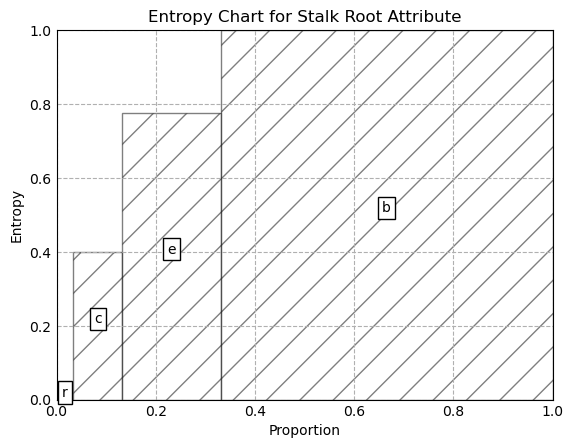

In [111]:
plot_attribute_entropy(stalkrt[0], stalkrt[1], stalkrt[0].index, stalkrt[2])